<b>Import libraries

In [1]:
import datetime
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
from optuna import create_study
from optuna.samplers import TPESampler
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import (RFE, SelectKBest,
                                       SequentialFeatureSelector,
                                       VarianceThreshold, chi2, f_classif,
                                       mutual_info_classif)
from sklearn.metrics import f1_score, precision_recall_curve, roc_curve
from sklearn.model_selection import (GridSearchCV, StratifiedKFold,
                                     cross_val_score)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier


In [2]:
PARENT_PATH = Path(os.getcwd()).parent
os.chdir(PARENT_PATH)

from notebooks.diagnostics import ClassificationDiagnostics
from notebooks.minmaxscaler import mmscaler

<b>Import dataset


In [3]:
DATA_PATH = os.path.join(Path(os.getcwd()), "data\\train_set.pkl")

In [4]:
with open(DATA_PATH,"rb") as f:
    dataset = pickle.load(f)
dataset

,Date,Index,daily_returns,momentum30,momentum60,momentum120,vs_quantile,vs_quantile_binary,vs_quantile_binary_freq,divergence,lag_returns,sell_signal
0,2010-06-25,4.579647,0.545185,98.852998,99.186729,99.445776,0.148886,0.0,0.083333,-0.030905,-2.193406,1
1,2010-06-28,4.580263,0.061532,99.368701,99.155543,99.465618,0.141364,0.0,0.083333,-0.031225,0.545185,1
2,2010-06-29,4.537961,-4.230111,98.279685,97.914172,98.598467,-1.823472,1.0,0.100000,-0.032261,0.061532,1
3,2010-06-30,4.523635,-1.432674,98.375237,97.596871,98.342961,-0.228739,0.0,0.100000,-0.032895,-4.230111,1
4,2010-07-01,4.522223,-0.141143,98.439591,97.601193,98.128629,0.136183,0.0,0.100000,-0.033432,-1.432674,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2896,2021-12-27,7.338830,2.007130,100.490500,101.924288,101.959527,0.445107,0.0,0.033333,0.025429,0.781389,0
2897,2021-12-28,7.334336,-0.449377,100.309045,101.708571,102.030084,0.113669,0.0,0.033333,0.024129,2.007130,0
2898,2021-12-29,7.337347,0.301111,100.382438,102.028622,101.880797,0.137352,0.0,0.033333,0.022629,-0.449377,0
2899,2021-12-30,7.330857,-0.648971,100.167129,101.782684,101.794794,0.093081,0.0,0.033333,0.020897,0.301111,0


<b> Specify model and set up cross validator

In [5]:
# XGBoost Classifier

model = XGBClassifier(use_label_encoder=False, eval_metric="logloss")

In [6]:
# Specify dependent variable and predictors

y = dataset.loc[:,"sell_signal"]
X = dataset.loc[:, dataset.columns.drop(["Date","Index","sell_signal"])]

In [7]:
# Change dtypes from object to float (required format by XGBoost)

objects = X.select_dtypes("object").columns

for column in objects:
    X[column] = pd.to_numeric(X[column])

X.dtypes

daily_returns              float64
momentum30                 float64
momentum60                 float64
momentum120                float64
vs_quantile                float64
vs_quantile_binary         float64
vs_quantile_binary_freq    float64
divergence                 float64
lag_returns                float64
dtype: object

In [8]:
# Cross Validator

cv = StratifiedKFold(n_splits = 10, shuffle=True, random_state=123)

# Generate train and test sets using stratified K-fold splits, decide if number of positive classes in train/test splits is sufficient

for train_idx, test_idx in cv.split(X,y):
    # print(train_idx)
    train_X, test_X = X.loc[train_idx, :], X.loc[test_idx,:]
    train_y, test_y = y[train_idx], y[test_idx]

    train_0, train_1 = len(train_y[train_y==0]), len(train_y[train_y==1])
    test_0, test_1 = len(test_y[test_y==0]), len(test_y[test_y==1])

    print(">Train: 0=%d, 1=%d, Test: 0=%d, 1=%d" % (train_0, train_1, test_0, test_1))

>Train: 0=2231, 1=379, Test: 0=248, 1=43
>Train: 0=2232, 1=379, Test: 0=247, 1=43
>Train: 0=2231, 1=380, Test: 0=248, 1=42
>Train: 0=2231, 1=380, Test: 0=248, 1=42
>Train: 0=2231, 1=380, Test: 0=248, 1=42
>Train: 0=2231, 1=380, Test: 0=248, 1=42
>Train: 0=2231, 1=380, Test: 0=248, 1=42
>Train: 0=2231, 1=380, Test: 0=248, 1=42
>Train: 0=2231, 1=380, Test: 0=248, 1=42
>Train: 0=2231, 1=380, Test: 0=248, 1=42


In [9]:
# Stratified K-Fold cross validation using F1 stat as model evaluation metric - focus on minority class
# Fit using all features

scores = cross_val_score(model, X, y, scoring = "f1", cv = cv, n_jobs = -1)
print("F1 score: %.3f (%.3f)" % (np.mean(scores), np.std(scores)))

F1 score: 0.884 (0.036)


<b> MinMaxScaler</b>  
Scale features

In [10]:
columns = X.columns
preprocessor = ColumnTransformer(
    [("minmaxscaler",MinMaxScaler(), columns)]
)

<b> Feature Selection</b>  
Can model perform better on limited number of features?

In [11]:
# Create dictionary to store selected features

feature_selection = {}
feature_selection["Features_set"] = X.columns.tolist()

<font size = 3><u> 1. Variance treshold optimization

In [12]:
# Parameters optimization

pipe = Pipeline(
    [("preprocessor", preprocessor), 
    ("selector", VarianceThreshold()),
    ("classifier",model)]
)

parameters = {
    "selector__threshold": [0.001, 0.0025, 0.005, 0.007, 0.01, 0.02, 0.03]   
}

grid = GridSearchCV(pipe, parameters, cv = cv, scoring = "f1").fit(X,y)

print(grid.best_params_)
print(grid.best_estimator_)
pd.DataFrame.from_dict(grid.cv_results_, orient = "columns")


{'selector__threshold': 0.007}
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  Index(['daily_returns', 'momentum30', 'momentum60', 'momentum120',
       'vs_quantile', 'vs_quantile_binary', 'vs_quantile_binary_freq',
       'divergence', 'lag_returns'],
      dtype='object'))])),
                ('selector', VarianceThreshold(threshold=0.007)),
                ('classifier',
                 XGBClassifier(base_sc...
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=8, num_parallel_tree=1, predictor='auto',
                       

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_selector__threshold,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,1.477563,0.755191,0.024949,0.008231,0.001,{'selector__threshold': 0.001},0.853659,0.860759,0.950000,0.837209,0.925000,0.819277,0.873563,0.911392,0.864865,0.867470,0.876319,0.038451,4
1,0.846354,0.428046,0.019229,0.004537,0.0025,{'selector__threshold': 0.0025},0.853659,0.860759,0.894118,0.837209,0.925000,0.819277,0.873563,0.911392,0.864865,0.867470,0.870731,0.030595,5
2,3.211039,3.077684,0.039456,0.016104,0.005,{'selector__threshold': 0.005},0.913580,0.925000,0.926829,0.829268,0.951220,0.878049,0.891566,0.909091,0.894737,0.878049,0.899739,0.032094,3
3,0.947809,0.375220,0.023091,0.003590,0.007,{'selector__threshold': 0.007},0.913580,0.925000,0.951220,0.829268,0.951220,0.878049,0.891566,0.909091,0.894737,0.878049,0.902178,0.034867,1
4,0.810068,0.057342,0.024467,0.004063,0.01,{'selector__threshold': 0.01},0.913580,0.925000,0.951220,0.829268,0.951220,0.878049,0.891566,0.909091,0.894737,0.878049,0.902178,0.034867,1
5,0.594620,0.169528,0.023788,0.006631,0.02,{'selector__threshold': 0.02},0.519481,0.611111,0.795181,0.567568,0.594595,0.533333,0.649351,0.550725,0.575342,0.657143,0.605383,0.076600,6
6,0.195191,0.015244,0.015402,0.001281,0.03,{'selector__threshold': 0.03},0.310345,0.222222,0.290909,0.218182,0.208333,0.262295,0.290909,0.290909,0.148148,0.163265,0.240552,0.054164,7


In [13]:
# Variance Threshold with optimized selector__threshold 0.007

pipe = Pipeline(
    [("preprocessor", preprocessor), 
    ("selector", VarianceThreshold(threshold=0.007)), 
    ("classifier", model)]
)

pipe.fit(X,y)
mask = pipe.named_steps["selector"].get_support()
features = X.columns[mask]

feature_selection["VarianceThreshold"] = features.tolist()

<b> Feature Selection</b>  
Can model perform better on limited number of features?

<font size = 3><u> 2. KBest univariate feature selection (chi2 test) optimization

In [14]:
# Parameters optimization

pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("selector", SelectKBest(chi2)), 
    ("classifier", model)
])

parameters = {"selector__k": range(1, X.shape[1])}

grid = GridSearchCV(pipe, parameters, cv=cv, scoring="f1").fit(X,y)

print(grid.best_params_)
print(grid.best_estimator_)

{'selector__k': 6}
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  Index(['daily_returns', 'momentum30', 'momentum60', 'momentum120',
       'vs_quantile', 'vs_quantile_binary', 'vs_quantile_binary_freq',
       'divergence', 'lag_returns'],
      dtype='object'))])),
                ('selector',
                 SelectKBest(k=6,
                             score_func=<function chi2 at 0x000001F119954D30>)),
                ('class...
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=8, num_parallel_tree=1, predictor='auto',
   

Text(0.5, 1.0, 'F1 score @ number of features')

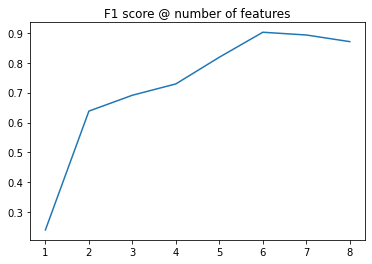

In [15]:
grid_output = pd.DataFrame.from_dict(grid.cv_results_, orient="columns")
plt.plot(range(1,X.shape[1]), grid_output.mean_test_score)
plt.title("F1 score @ number of features")

In [16]:
pipe = Pipeline([
    ("preprocessor", preprocessor), 
    ("selector", SelectKBest(mutual_info_classif, k = 6)), 
    ("classifier",model)])

pipe.fit(X,y)
mask = pipe.named_steps["selector"].get_support()
features = X.columns[mask]

feature_selection["KBest_mic"] = features.tolist()

<font size = 3><u> 3. KBest univariate feature selection (f_classif test) optimization

In [17]:
# Parameters optimization

pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("selector", SelectKBest(f_classif)), 
    ("classifier",model)
])

parameters = {"selector__k": range(1, X.shape[1])}

grid = GridSearchCV(pipe, parameters, cv=cv, scoring="f1").fit(X,y)

print(grid.best_params_)
print(grid.best_estimator_)

{'selector__k': 6}
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  Index(['daily_returns', 'momentum30', 'momentum60', 'momentum120',
       'vs_quantile', 'vs_quantile_binary', 'vs_quantile_binary_freq',
       'divergence', 'lag_returns'],
      dtype='object'))])),
                ('selector', SelectKBest(k=6)),
                ('classifier',
                 XGBClassifier(base_score=0.5, booster='g...
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=8, num_parallel_tree=1, predictor='auto',
                               ran

Text(0.5, 1.0, 'F1 score @ number of features')

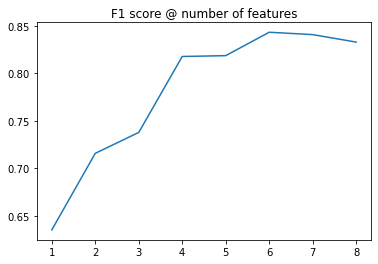

In [18]:
grid_output = pd.DataFrame.from_dict(grid.cv_results_, orient="columns")
plt.plot(range(1,X.shape[1]), grid_output.mean_test_score)
plt.title("F1 score @ number of features")

In [19]:
pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("selector", SelectKBest(f_classif, k = 6)), 
    ("classifier",model)])

pipe.fit(X,y)
mask = pipe.named_steps["selector"].get_support()
features = X.columns[mask]

feature_selection["KBest_ftest"] = features.tolist()

<font size = 3><u> 4. Recursive feature elimination optimization

In [20]:
pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("selector", RFE(model, step = 1)),
    ("classifier", model)])

parameters = {"selector__n_features_to_select": range(1, X.shape[1])}

grid = GridSearchCV(pipe, parameters, cv = cv, scoring = "f1").fit(X,y)

print(grid.best_params_)
print(grid.best_estimator_)

{'selector__n_features_to_select': 6}
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  Index(['daily_returns', 'momentum30', 'momentum60', 'momentum120',
       'vs_quantile', 'vs_quantile_binary', 'vs_quantile_binary_freq',
       'divergence', 'lag_returns'],
      dtype='object'))])),
                ('selector',
                 RFE(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                             colsample_b...
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=8, num_parallel_tree=1, predi

Text(0.5, 1.0, 'F1 score @ number of features')

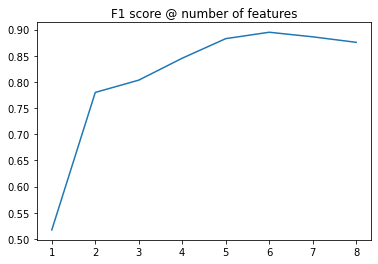

In [21]:
grid_output = pd.DataFrame.from_dict(grid.cv_results_, orient = "columns")
plt.plot(range(1,X.shape[1]), grid_output.mean_test_score)
plt.title("F1 score @ number of features")

In [22]:
pipe = Pipeline([
    ("preprocessor", preprocessor), 
    ("selector", RFE(model, n_features_to_select = 6, step = 1)), 
    ("classifier", model)])

pipe.fit(X,y)
mask = pipe.named_steps["selector"].get_support()
features = X.columns[mask]

feature_selection["RFE"] = features.tolist()

<font size = 3><u> 5. Sequential Feature Selector optimization  
\>> forward


In [23]:
pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("selector", SequentialFeatureSelector(model, n_features_to_select = 6, direction = "forward")), 
    ("classifier", model)])

pipe.fit(X,y)
mask = pipe.named_steps["selector"].get_support()
features = X.columns[mask]

feature_selection["forward_select"] = features.tolist()

<font size = 3><u> 5. Sequential Feature Selector optimization  
\>> backward

In [24]:
pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("selector", SequentialFeatureSelector(model, n_features_to_select = 6, direction = "backward")), 
    ("classifier", model)])

pipe.fit(X,y)
mask = pipe.named_steps["selector"].get_support()
features = X.columns[mask]

feature_selection["backward_select"] = features.tolist()

<font size = 3><u> Best subset classification according to F1 score

In [25]:
# Default model

cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 1)
model = XGBClassifier(use_label_encoder=False, eval_metric="logloss")

pipe = Pipeline([
    ("MinMaxScaler", MinMaxScaler()), 
    ("classifier", model)]
)

f1_scores = {}
for key in feature_selection.keys():
    columns = feature_selection[key]
    x = X[columns]
    scores = cross_val_score(pipe, x, y, cv=cv, scoring = "f1", n_jobs=-1)
    score = np.mean(scores)
    f1_scores[key] = score

sorted(f1_scores.items(), key = lambda item: item[1], reverse = True)

[('VarianceThreshold', 0.9054012345679012),
 ('RFE', 0.8977564829382574),
 ('Features_set', 0.8927330212452104),
 ('KBest_ftest', 0.8050138590631744),
 ('KBest_mic', 0.8006292305236468),
 ('forward_select', 0.7860589041264296),
 ('backward_select', 0.7860589041264296)]

Best F1 score is achieved with VarianceThreshold

<font size = 3><u> Put it all together: rank features according to their presence in different filtering methods

In [26]:
features_df = pd.DataFrame({"Feature": feature_selection["Features_set"]})

filter_methods = list(feature_selection.keys())[1:]

for filter in filter_methods:
    features_df.loc[:, filter] = False
    features_df.loc[features_df["Feature"].isin(feature_selection[filter]),filter] = True

features_df["COUNT"] = features_df.iloc[:,1:].sum(axis = 1) # add COUNT column
features_df.sort_values(by=["COUNT"], ascending = False, inplace = True) # sort by COUNT column in descending order
features_df = features_df.reset_index(drop=True)
features_df

,Feature,VarianceThreshold,KBest_mic,KBest_ftest,RFE,forward_select,backward_select,COUNT
0,momentum60,True,True,True,True,True,True,6
1,daily_returns,False,True,True,True,True,True,5
2,momentum30,True,True,True,True,False,False,4
3,momentum120,True,True,True,True,False,False,4
4,vs_quantile_binary,True,False,True,False,True,True,4
5,vs_quantile_binary_freq,True,False,False,True,True,True,4
6,divergence,True,True,True,True,False,False,4
7,lag_returns,False,True,False,False,True,True,3
8,vs_quantile,False,False,False,False,True,True,2


In [27]:
# According to F1 score VarianceThreshold subset is superior.
# Can the result be improved with subset >3? 

model = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
pipe = Pipeline([
    ("MinMaxScaler", MinMaxScaler()),
    ("classifier", model)])

features1 = features_df.loc[features_df.COUNT >= 3,"Feature"].tolist()
features1

x = X[features1]

scores = cross_val_score(pipe, x, y, cv=cv, scoring = "f1", n_jobs=-1)
score = np.mean(scores)
print("Score for feature1 subset: %.3f" % score)

Score for feature1 subset: 0.885


In [28]:
# Feature1 subset did not outperform VarianceThreshold subset. Hence, continue with second. 

<b> Model Optimization </b>  
Optimization of parameters with Optuna

In [29]:
features = feature_selection["VarianceThreshold"]
features

['momentum30',
 'momentum60',
 'momentum120',
 'vs_quantile_binary',
 'vs_quantile_binary_freq',
 'divergence']

In [30]:
# Specify dependent variable and predictors

y = dataset.loc[:,"sell_signal"]
X = dataset.loc[:, features]

In [31]:
# Change dtypes from object to float (required format by XGBoost)

objects = X.select_dtypes("object").columns

for column in objects:
    X[column] = pd.to_numeric(X[column])

X.dtypes

momentum30                 float64
momentum60                 float64
momentum120                float64
vs_quantile_binary         float64
vs_quantile_binary_freq    float64
divergence                 float64
dtype: object

In [32]:
preprocessor = ColumnTransformer(
    remainder="passthrough", transformers=[("mm", MinMaxScaler(), features)]
)
pipe=Pipeline(steps=[("preprocessor", preprocessor)])

In [33]:
# Create objective function for hyperparameters optimization with Optuna

def objective(trial, X, y, random_state = 123, n_splits = 10):

    y_ = []
    prob_ = []
    class_ = []

    #XGBoost parameters
    params = {
        "verbosity": 0, # verbosity of printing messages; 0 (silent), 1 (warning), 2 (info), 3 (debug) 
        "objective": "binary:logistic", # learning task and corresponding learning objective; output probability in this case
        "n_estimators": 10000, # number of boosting rounds
        "max_depth": trial.suggest_int("max_depth", 1, 12, step = 1), # maximum tree depth for base learners
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.005, 0.05), # boosting learning rate
        "colsample_bytree": trial.suggest_loguniform("colsample_bytree", 0.2, 1), # subsample ratio of columns when constructing each tree
        "subsample": trial.suggest_loguniform("subsample", 0.4, 1), # subsample ratio of the training instance
        "alpha": trial.suggest_loguniform("alpha", 0.01, 10.0), # L1 regularization term on weights
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 10.0), # L2 regularization term on weights 
        "gamma": trial.suggest_loguniform("gamma", 1e-8, 10.0), # min. loss reduction required to make a further partition on a leaf node of the tree
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 1, 1000), # minimum sum of instance weight (hessian) needed in a child
        "seed": random_state, # random number seed
        "n_jobs": 1,
        "use_label_encoder": False, 
        "eval_metric": "logloss"
    }

    model = XGBClassifier(**params)
    cv = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state=random_state)

    def f1_eval(y_pred, dtrain):
        y_true = dtrain.get_label()
        err = 1-f1_score(y_true, np.round(y_pred, 0).astype("bool"), average="binary")
        return 'f1_err', err

    for train_idx, test_idx in cv.split(X,y):
        train_X, test_X = pipe.fit_transform(X.loc[train_idx, :]), pipe.fit_transform(X.loc[test_idx, :])
        train_y, test_y = y[train_idx], y[test_idx]
      
        res = model.fit(train_X, train_y, eval_set = [(test_X, test_y)], eval_metric=f1_eval, verbose = 0, early_stopping_rounds=100)
        probability_test = res.predict_proba(test_X)[:,1]
        class_test = res.predict(test_X)
        
        y_ += test_y.tolist()
        prob_ += probability_test.tolist()
        class_ += class_test.tolist()

        return 1-f1_score(y_,class_)

In [34]:
# Create study wrt. objective function minimization

from warnings import simplefilter
simplefilter("ignore", category=UserWarning)
simplefilter("ignore", category=FutureWarning)
optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=124)
study = create_study(direction="minimize", sampler = sampler) # minimize (1 - f1_score) error
study.optimize(lambda trial: objective(trial, X, y), n_trials = 100, n_jobs = 1)

In [35]:
# Print results of optimized model

hp = study.best_params
for key, value in hp.items():
    print(f"{key:>20s} : {value}")
print(f"{'best objective value':>20s} : {study.best_value}")

           max_depth : 7
       learning_rate : 0.022094234577759216
    colsample_bytree : 0.8427237650025714
           subsample : 0.8175919965588061
               alpha : 3.768923163198001
              lambda : 0.16727326587860838
               gamma : 1.562717477716257e-05
    min_child_weight : 2.116247357089965
best objective value : 0.1842105263157895


In [36]:
hp["verbosity"] = 0
hp["objective"] = "binary:logistic"
hp["n_estimators"] = 10000
hp["seed"] = 123
hp["n_jobs"] = 1

cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state=123)
model = XGBClassifier(**hp)
res = model.fit(X,y)

In [37]:
hp

{'max_depth': 7,
 'learning_rate': 0.022094234577759216,
 'colsample_bytree': 0.8427237650025714,
 'subsample': 0.8175919965588061,
 'alpha': 3.768923163198001,
 'lambda': 0.16727326587860838,
 'gamma': 1.562717477716257e-05,
 'min_child_weight': 2.116247357089965,
 'verbosity': 0,
 'objective': 'binary:logistic',
 'n_estimators': 10000,
 'seed': 123,
 'n_jobs': 1}

<b> Model Diagnostics </b>

In [38]:
model

XGBClassifier(alpha=3.768923163198001, base_score=0.5, booster='gbtree',
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.8427237650025714, enable_categorical=False,
              gamma=1.562717477716257e-05, gpu_id=-1, importance_type=None,
              interaction_constraints='', lambda=0.16727326587860838,
              learning_rate=0.022094234577759216, max_delta_step=0, max_depth=7,
              min_child_weight=2.116247357089965, missing=nan,
              monotone_constraints='()', n_estimators=10000, n_jobs=1,
              num_parallel_tree=1, predictor='auto', random_state=123,
              reg_alpha=3.76892328, reg_lambda=0.167273268, scale_pos_weight=1,
              seed=123, subsample=0.8175919965588061, tree_method='exact',
              validate_parameters=1, ...)

In [39]:
features

['momentum30',
 'momentum60',
 'momentum120',
 'vs_quantile_binary',
 'vs_quantile_binary_freq',
 'divergence']

In [40]:
# Model diagnostics on 10-fold stratified data

pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", model)])

ys = []
probabilities = []
classes = []

for train, test in cv.split(X[features],y):
    X_train, X_test = X.loc[train,:], X.loc[test,:]
    y_train, y_test = y[train], y[test]

    pipe.fit(X_train,y_train)
    probability_test = pipe.predict_proba(X_test)[:,1]
    class_test = [True if x > 0.5 else False for x in probability_test]

    ys += y_test.tolist()
    probabilities += probability_test.tolist()
    classes += class_test

In [41]:
# Model diagnostics on 10-fold stratified data

pipe = Pipeline([
    ("minmaxscaler", MinMaxScaler()),
    ("classifier", model)])

ys = []
probabilities = []
classes = []

for train, test in cv.split(X[features],y):
    X_train, X_test = X.loc[train,:], X.loc[test,:]
    y_train, y_test = y[train], y[test]

    pipe.fit(X_train,y_train)
    probability_test = pipe.predict_proba(X_test)[:,1]
    class_test = [True if x > 0.5 else False for x in probability_test]

    ys += y_test.tolist()
    probabilities += probability_test.tolist()
    classes += class_test

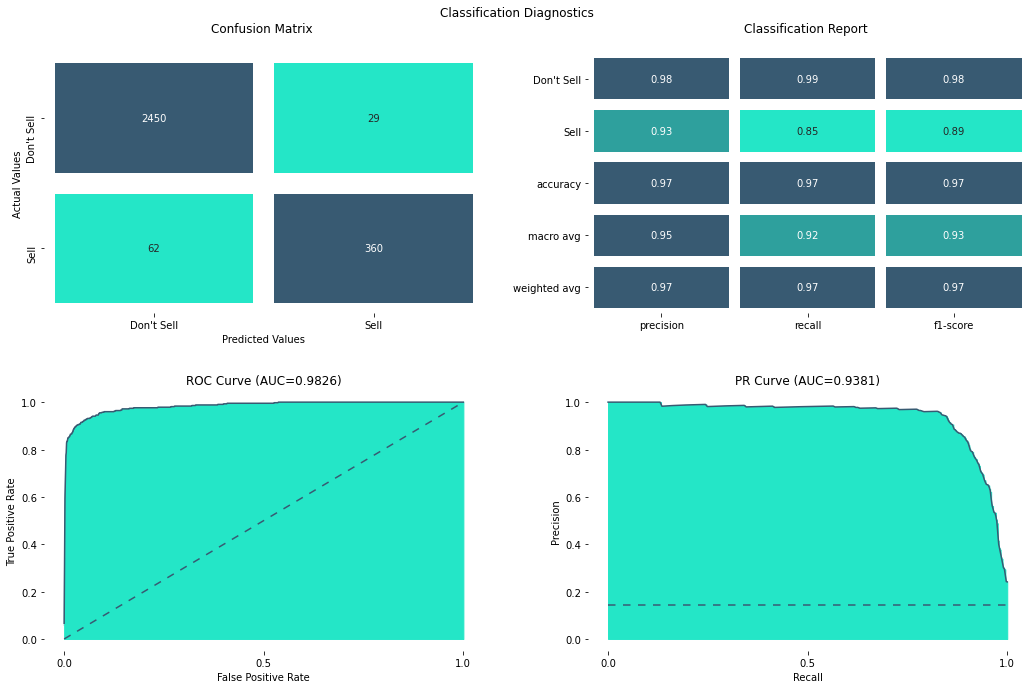

In [42]:
# Perform model CV diagnostics 

ClassificationDiagnostics(ys, classes, probabilities).plotDiagnostics()

In [43]:
# Finding optimal threshold for ROC curve - G-Mean

fpr, tpr, thresholds = roc_curve(ys, probabilities)

gmeans = np.sqrt(tpr * (1 - fpr))
idx = np.argmax(gmeans)
print("Best threshold = %f, G-Mean = %.3f" % (thresholds[idx], gmeans[idx]))

Best threshold = 0.150855, G-Mean = 0.937


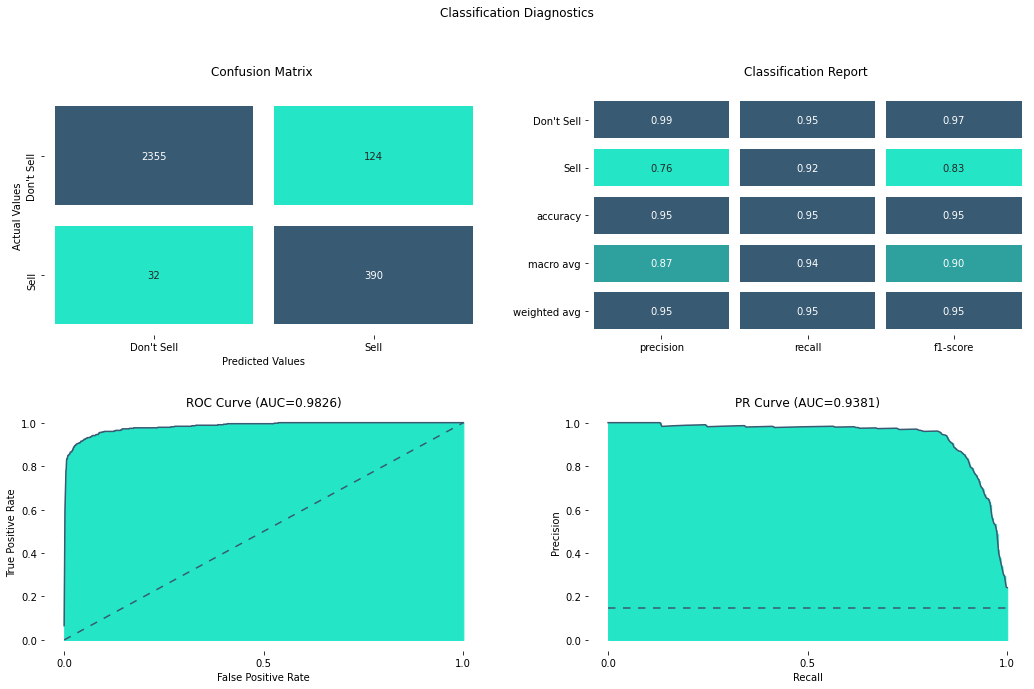

In [44]:
# For threshold 0.123638 generate diagnostics

threshold = thresholds[idx]
classes = [True if x >= threshold else False for x in probabilities]

ClassificationDiagnostics(ys, classes, probabilities).plotDiagnostics()

In [45]:
# Finding optimal threshold for ROC curve - Youden's J statistic

fpr, tpr, thresholds = roc_curve(ys, probabilities)

J = tpr - fpr
idx = np.argmax(J)
print("Best threshold = %f, J = %.3f" % (thresholds[idx], J[idx]))

Best threshold = 0.150855, J = 0.874


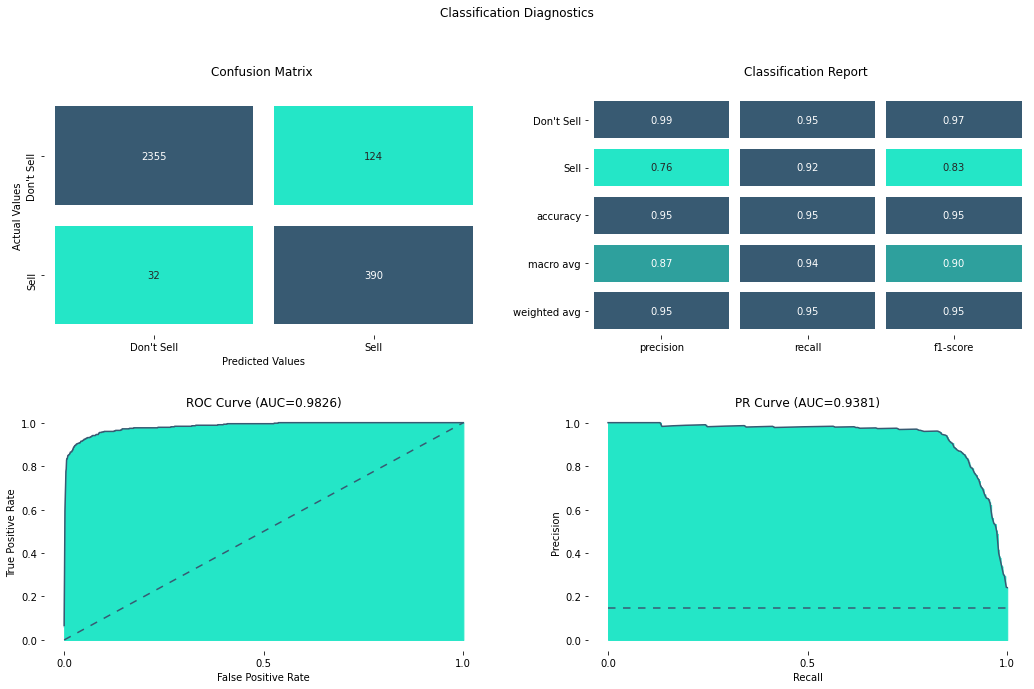

In [46]:
# For threshold 0.123638 generate diagnostics

threshold = thresholds[idx]
classes = [True if x >= threshold else False for x in probabilities]

ClassificationDiagnostics(ys, classes, probabilities).plotDiagnostics()

In [47]:
# Finding optimal threshold for PR curve - F-Measure

precision, recall, thresholds = precision_recall_curve(ys, probabilities)

fscore = (2 * precision * recall) / (precision + recall)
idx = np.argmax(fscore)
print("Best threshold = %f, F-Score = %.3f" % (thresholds[idx], fscore[idx]))

Best threshold = 0.549713, F-Score = 0.893


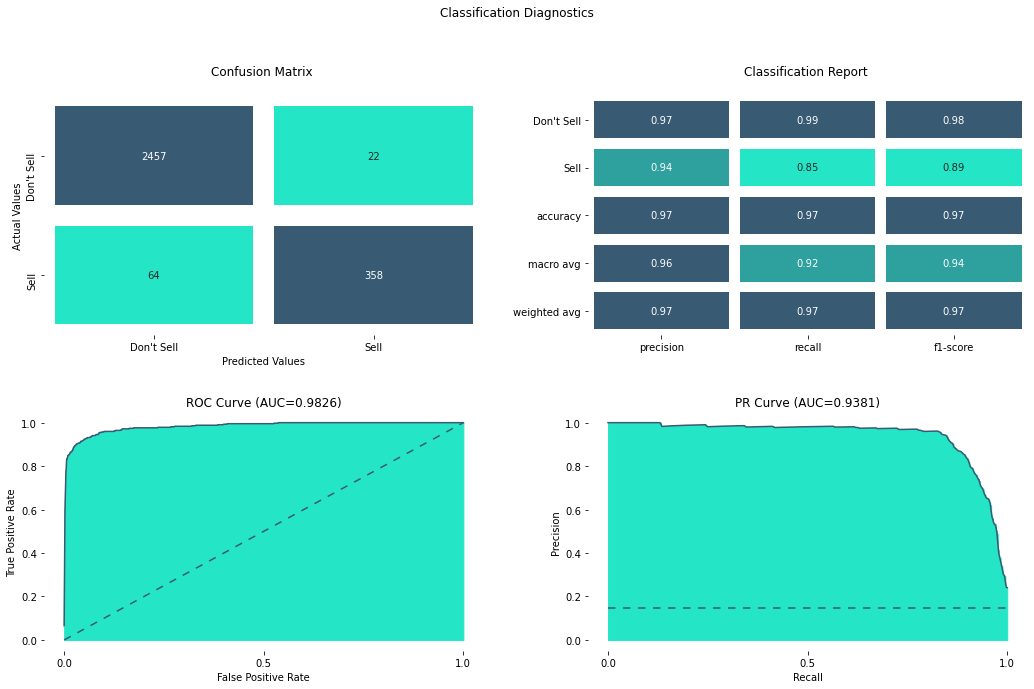

In [48]:
# FMeasure outputs threshold of = 0.452418. For this value, let's reprint diagnostics

threshold = thresholds[idx]
classes = [True if x >= threshold else False for x in probabilities]

ClassificationDiagnostics(ys, classes, probabilities).plotDiagnostics()

<b> Predict and plot from model w/ validation set

In [49]:
DATA_PATH = os.path.join(Path(os.getcwd()), "data\\data.pkl")

In [50]:
with open(DATA_PATH,"rb") as f:
    df = pickle.load(f)
df

,Date,Index,daily_returns,momentum30,momentum60,momentum120,vs_quantile,vs_quantile_binary,vs_quantile_binary_freq,divergence,lag_returns,sell_signal
0,2010-06-25,4.579647,0.545185,98.852998,99.186729,99.445776,0.148886,0.0,0.083333,-0.030905,-2.193406,1
1,2010-06-28,4.580263,0.061532,99.368701,99.155543,99.465618,0.141364,0.0,0.083333,-0.031225,0.545185,1
2,2010-06-29,4.537961,-4.230111,98.279685,97.914172,98.598467,-1.823472,1.0,0.100000,-0.032261,0.061532,1
3,2010-06-30,4.523635,-1.432674,98.375237,97.596871,98.342961,-0.228739,0.0,0.100000,-0.032895,-4.230111,1
4,2010-07-01,4.522223,-0.141143,98.439591,97.601193,98.128629,0.136183,0.0,0.100000,-0.033432,-1.432674,1
...,...,...,...,...,...,...,...,...,...,...,...,...
3065,2022-08-29,7.114973,-1.253641,100.828226,99.298478,99.694806,-0.143307,0.0,0.133333,0.047900,-4.490781,0
3066,2022-08-30,7.106327,-0.864527,100.174558,99.445044,99.143211,0.043200,0.0,0.133333,0.048974,-1.253641,0
3067,2022-08-31,7.096771,-0.955636,99.784020,99.277308,99.218188,0.010588,0.0,0.133333,0.049323,-0.864527,0
3068,2022-09-01,7.090852,-0.591951,99.476282,99.072472,99.324979,0.095327,0.0,0.133333,0.049185,-0.955636,0


In [58]:
X = df[features]
ppred = pipe.predict_proba(X)[:,1]
cpred = [1 if x>= threshold else 0 for x in ppred]

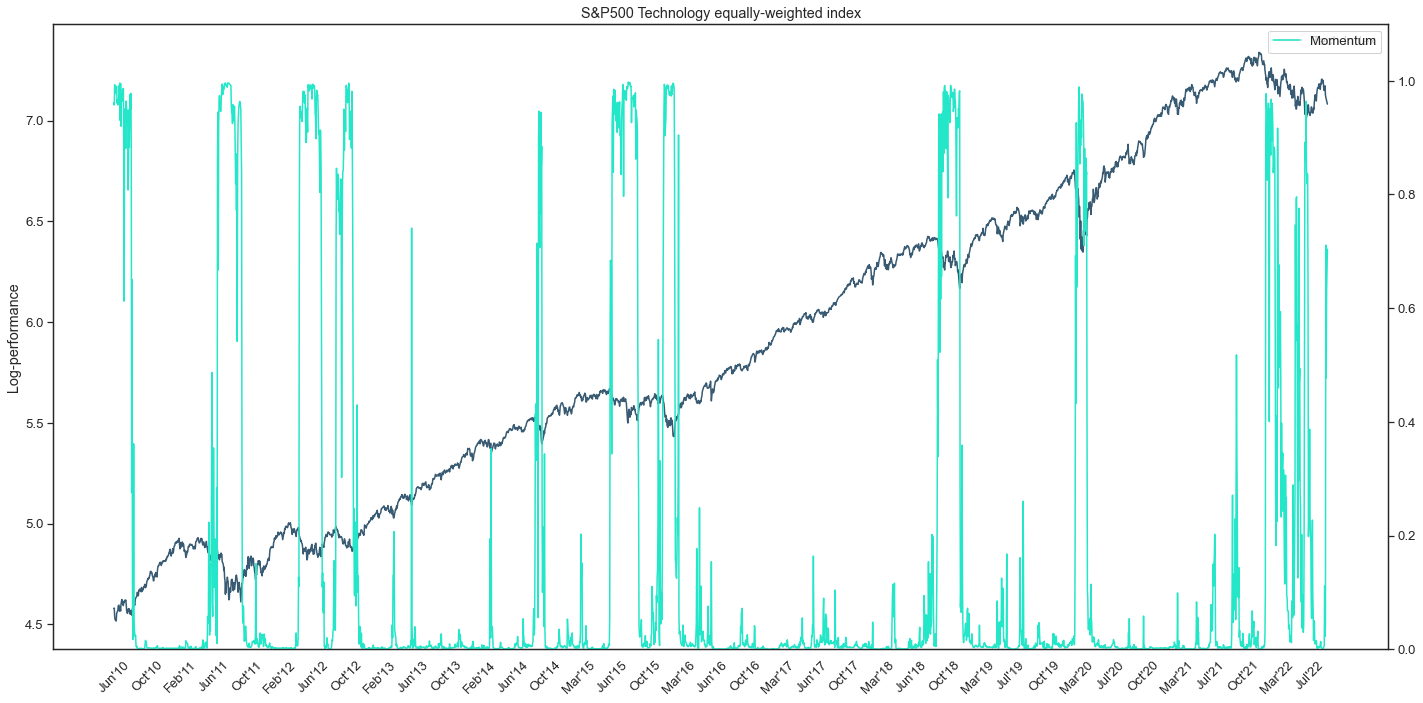

In [61]:
# Plot momentum against S&P Tech

# Where those points lie on time series chart?

# Prepare data for time series chart

index = df.loc[:, "Index"]
dates = df.loc[:, "Date"]
prediction = ppred

labels_freq = np.arange(1, len(index), 21*4)

labels = []
for i in labels_freq:
    date = dates[i]
    date = datetime.datetime.strptime(date, "%Y-%m-%d")
    date = datetime.datetime.strftime(date, "%b'%y")
    labels.append(date)

fig, ax = plt.subplots(figsize=(20, 10))

sns.set(style="white", font_scale=1.2)

sns.lineplot(y=index, x=range(len(index)), ax=ax, color="#385A72", lw=1.5)

ax2 = ax.axes.twinx()
sns.lineplot(y=prediction, x=range(len(index)), color="#24E6C8", lw=1.5, ax = ax2)

ax.set_title(f"S&P500 Technology equally-weighted index")
ax.set_ylabel("Log-performance")
ax.xaxis.set_ticks(labels_freq)
ax.set_xticklabels(labels)
ax.tick_params(axis = "x", rotation = 45)
ax.legend(labels = ['Tech Index'])

ax2.legend(labels = ['Momentum'])
ax2.set_ylim(0,1.1)

ax.set_facecolor('white')
plt.tight_layout()

<b> Save the model & features

In [92]:
MODEL_PATH = Path(os.path.join(os.getcwd(),"model\\xgboost.txt"))
model.save_model(MODEL_PATH)

WindowsPath('c:/Users/lukas/OneDrive/Pulpit/data-science/Projects/bear_markets/ml_algo/model/xgboost.txt')

In [120]:
FEATURES_PATH = Path(os.path.join(os.getcwd(), "model\\features.txt"))

with open(FEATURES_PATH, "w") as f:
    for feature in features:
        f.write(f"{feature}\n")

In [130]:
features = []
with open(FEATURES_PATH, "r") as f:
    lines = f.readlines()
    for line in lines:
        features.append(line.strip("\n"))

<b> WORKINGS